In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from lime import lime_image
from skimage.segmentation import mark_boundaries, slic
from sklearn.preprocessing import LabelEncoder

/home/tony/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ClusterAnalyzer:
    def __init__(self, base_path='data/b_fig_cluster', image_size=(256, 256)):
        self.base_path = base_path
        self.image_size = image_size
        self.label_encoder = LabelEncoder()
        
    def load_dataset(self):
        images = []
        labels = []
        paths = []
        
        for cluster_dir in sorted(os.listdir(self.base_path)):
            if cluster_dir.startswith('cluster_'):
                cluster_path = os.path.join(self.base_path, cluster_dir)
                if os.path.isdir(cluster_path):
                    for img_name in os.listdir(cluster_path):
                        if img_name.endswith(('.png')):
                            img_path = os.path.join(cluster_path, img_name)
                            try:
                                img = Image.open(img_path).convert('L')
                                # print(img.size)
                                img = img.resize(self.image_size)
                                img_array = np.array(img)
                                img_array = img_array / 255.0
                                # Add channel dimension for consistency with LIME
                                img_array = np.expand_dims(img_array, axis=-1)
                                # Repeat the channel 3 times for LIME compatibility
                                img_array = np.repeat(img_array, 3, axis=-1)
                                images.append(img_array)
                                labels.append(cluster_dir)
                                paths.append(img_path)
                            except Exception as e:
                                print(f"Error loading {img_path}: {e}")
        
        self.images = np.array(images)
        self.encoded_labels = self.label_encoder.fit_transform(labels)
        self.image_paths = paths
        return self.images, self.encoded_labels
    
    def train_surrogate_model(self):
        n_samples = self.images.shape[0]
        flat_data = self.images.reshape((n_samples, -1))
        
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        self.classifier.fit(flat_data, self.encoded_labels)
        
    def predict_fn(self, images):
        reshaped_images = images.reshape(images.shape[0], -1)
        probas = self.classifier.predict_proba(reshaped_images)
        return probas
    
    def analyze_cluster(self, cluster_num, num_samples=3):
        cluster_indices = np.where(self.encoded_labels == cluster_num)[0]
        
        sample_indices = np.random.choice(cluster_indices, 
                                        size=min(num_samples, len(cluster_indices)), 
                                        replace=False)
        
        explainer = lime_image.LimeImageExplainer()
        
        for idx in sample_indices:
            image = self.images[idx]
            
            # Generate explanation
            explanation = explainer.explain_instance(
                image, 
                self.predict_fn,
                top_labels=1,
                hide_color=0,
                num_samples=100,
                segmentation_fn=lambda x: slic(x, n_segments=50, compactness=30)
            )
            
            # Plot results
            plt.figure(figsize=(12, 4))
            
            # Original image
            plt.subplot(131)
            plt.imshow(image)
            plt.title(f'Original Image\nCluster {cluster_num}')
            plt.axis('off')
            
            # Get explanation mask
            temp, mask = explanation.get_image_and_mask(
                explanation.top_labels[0],
                positive_only=True,
                num_features=5,
                hide_rest=False
            )
            
            plt.subplot(132)
            plt.imshow(mark_boundaries(temp, mask))
            plt.title('Important Regions\n(Positive Evidence)')
            plt.axis('off')
            
            plt.subplot(133)
            exp_img = explanation.get_image_and_mask(
                explanation.top_labels[0],
                positive_only=False,
                num_features=10,
                hide_rest=False
            )[1]
            plt.imshow(exp_img, cmap='RdBu', vmin=-1, vmax=1)
            plt.title('Feature Importance\nHeatmap')
            plt.colorbar()
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"\nTop features for image {os.path.basename(self.image_paths[idx])}:")
            temp = explanation.local_exp[explanation.top_labels[0]]
            for feature, importance in sorted(temp, key=lambda x: abs(x[1]), reverse=True)[:5]:
                print(f"Feature {feature}: Importance = {importance:.3f}")

In [3]:
def load_data(base_path='data/a_cluster'):

    all_samples = []
    all_labels = []
    
    cluster_dirs = sorted([d for d in os.listdir(base_path) if d.startswith('cluster_')])
    
    for cluster_idx, cluster_dir in enumerate(cluster_dirs):
        cluster_path = os.path.join(base_path, cluster_dir)
        
        if os.path.isdir(cluster_path):
            npy_files = sorted([f for f in os.listdir(cluster_path) if f.endswith('.npy')])
            
            for npy_file in npy_files:
                file_path = os.path.join(cluster_path, npy_file)
                data = np.load(file_path)
                data = data[:409, :]
                data_flat = data.flatten() 
                all_samples.append(data_flat)
                all_labels.append(cluster_idx)
    
    X = np.array(all_samples)
    cluster_labels = np.array(all_labels)
    
    return X, cluster_labels

Loading dataset...
Training surrogate model...

Analyzing Cluster 0...


100%|██████████| 100/100 [00:00<00:00, 542.57it/s]


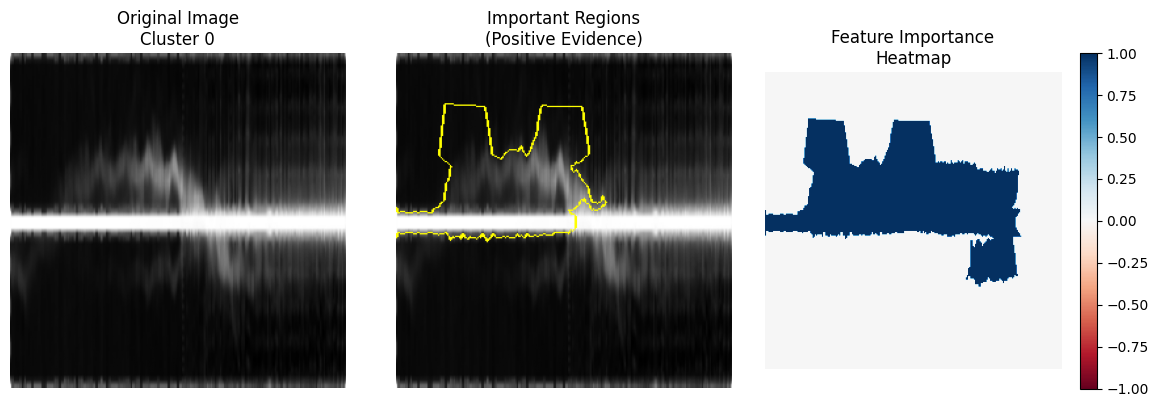


Top features for image A_11.png:
Feature 19: Importance = 0.072
Feature 15: Importance = 0.065
Feature 11: Importance = 0.052
Feature 16: Importance = 0.044
Feature 12: Importance = 0.038


100%|██████████| 100/100 [00:00<00:00, 559.91it/s]


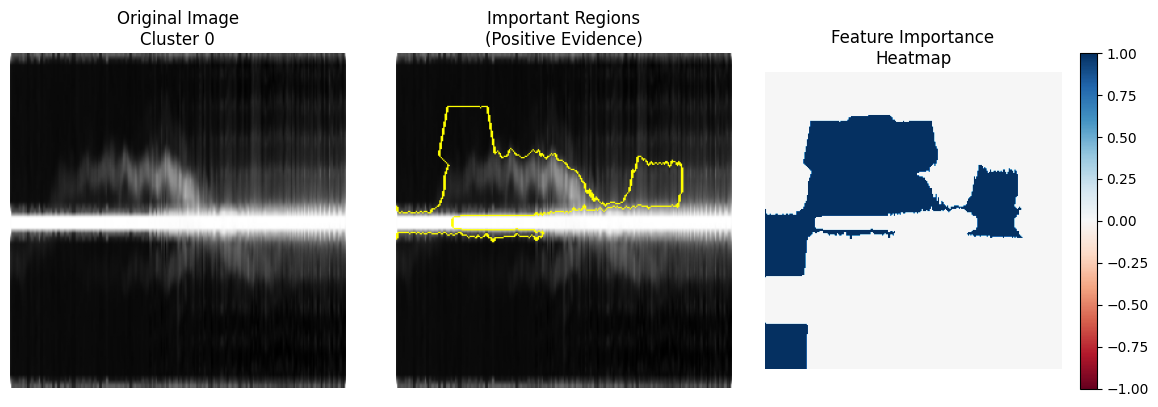


Top features for image B_9.png:
Feature 21: Importance = 0.074
Feature 15: Importance = 0.062
Feature 18: Importance = 0.044
Feature 12: Importance = 0.029
Feature 20: Importance = 0.028

Analyzing Cluster 1...


100%|██████████| 100/100 [00:00<00:00, 574.13it/s]


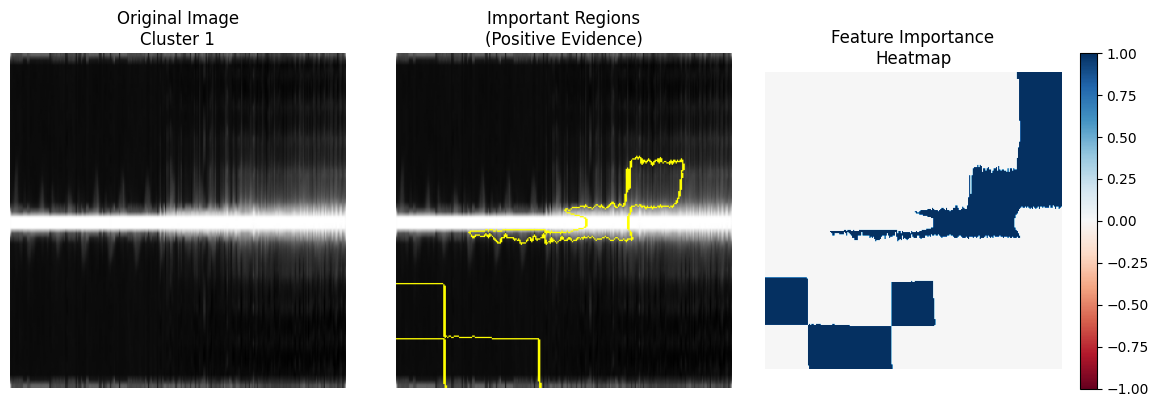


Top features for image C_0.png:
Feature 46: Importance = 0.071
Feature 43: Importance = 0.054
Feature 37: Importance = 0.046
Feature 19: Importance = 0.038
Feature 22: Importance = 0.035


100%|██████████| 100/100 [00:00<00:00, 553.35it/s]


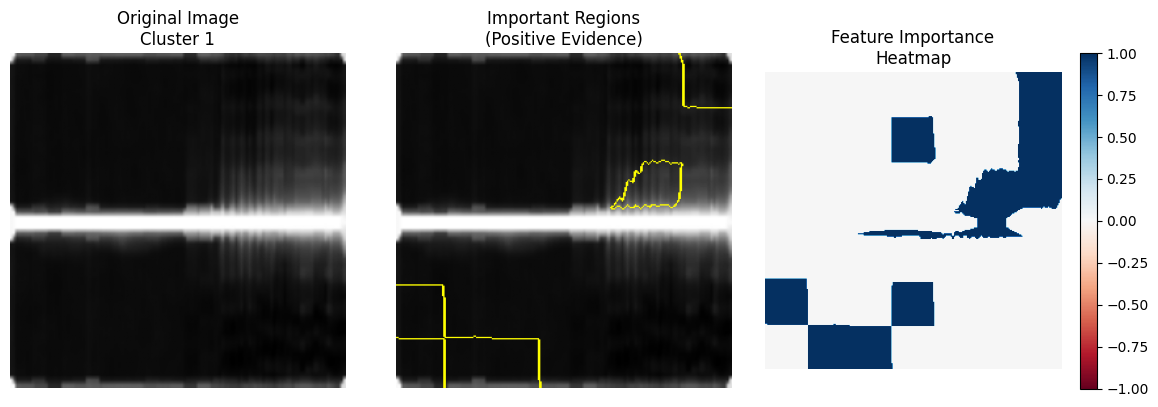


Top features for image B_7.png:
Feature 44: Importance = 0.069
Feature 21: Importance = 0.063
Feature 35: Importance = 0.056
Feature 42: Importance = 0.055
Feature 7: Importance = 0.044


100%|██████████| 100/100 [00:00<00:00, 579.75it/s]


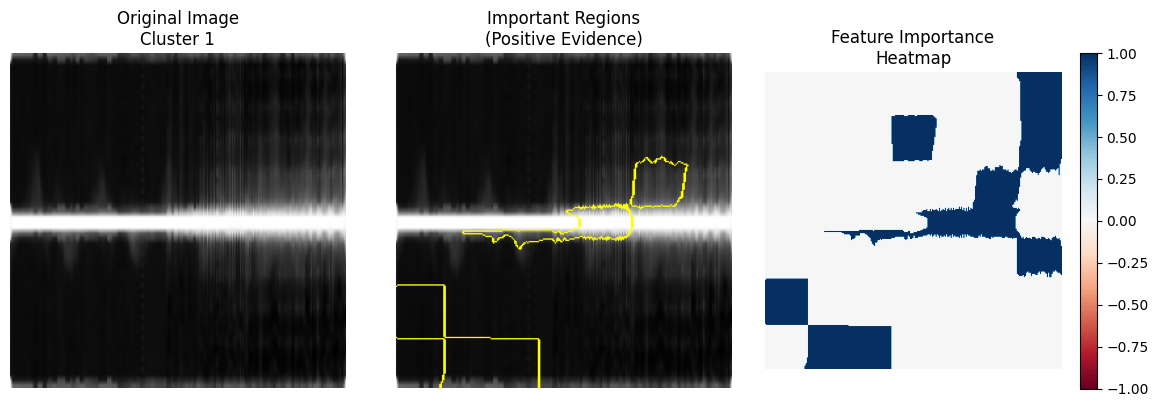


Top features for image C_2.png:
Feature 45: Importance = 0.059
Feature 37: Importance = 0.059
Feature 20: Importance = 0.058
Feature 44: Importance = 0.056
Feature 24: Importance = 0.038

Analyzing Cluster 2...


100%|██████████| 100/100 [00:00<00:00, 585.89it/s]


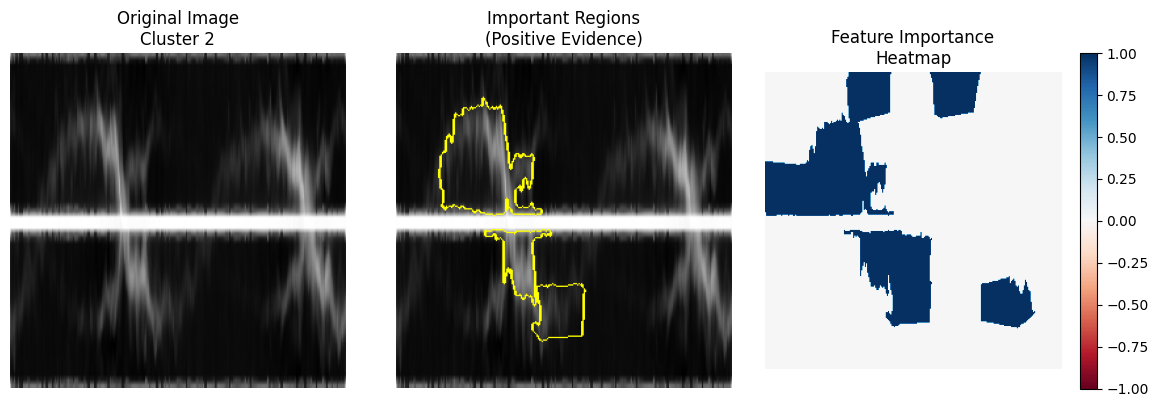


Top features for image C_3.png:
Feature 16: Importance = 0.128
Feature 15: Importance = 0.082
Feature 8: Importance = 0.065
Feature 39: Importance = 0.039
Feature 27: Importance = 0.028


100%|██████████| 100/100 [00:00<00:00, 563.99it/s]


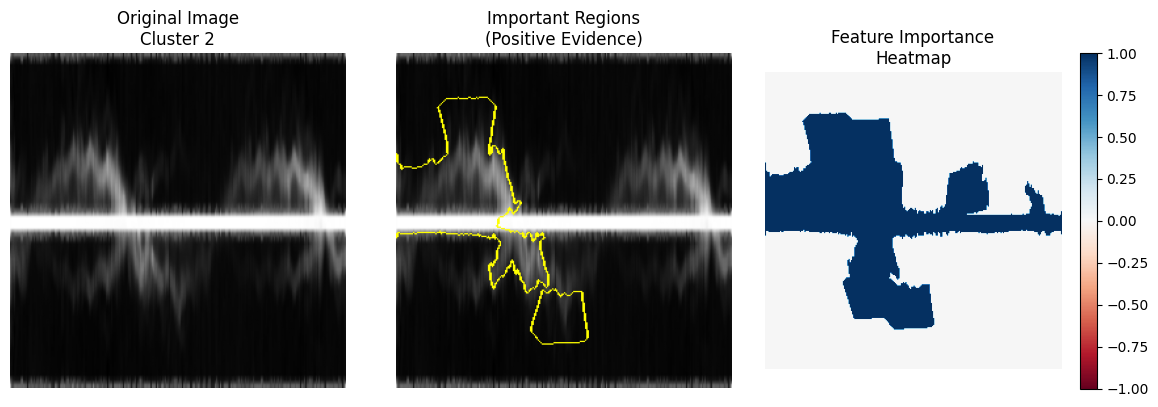


Top features for image A_9.png:
Feature 15: Importance = 0.108
Feature 21: Importance = 0.078
Feature 8: Importance = 0.068
Feature 36: Importance = 0.047
Feature 24: Importance = 0.027


100%|██████████| 100/100 [00:00<00:00, 550.48it/s]


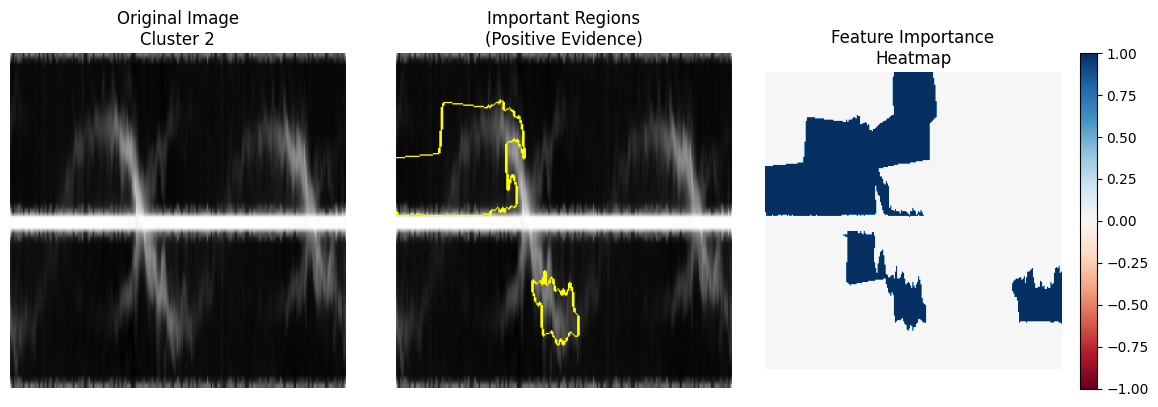


Top features for image C_4.png:
Feature 17: Importance = 0.087
Feature 13: Importance = 0.075
Feature 19: Importance = 0.065
Feature 34: Importance = 0.053
Feature 8: Importance = 0.048

Analyzing Cluster 3...


100%|██████████| 100/100 [00:00<00:00, 580.23it/s]


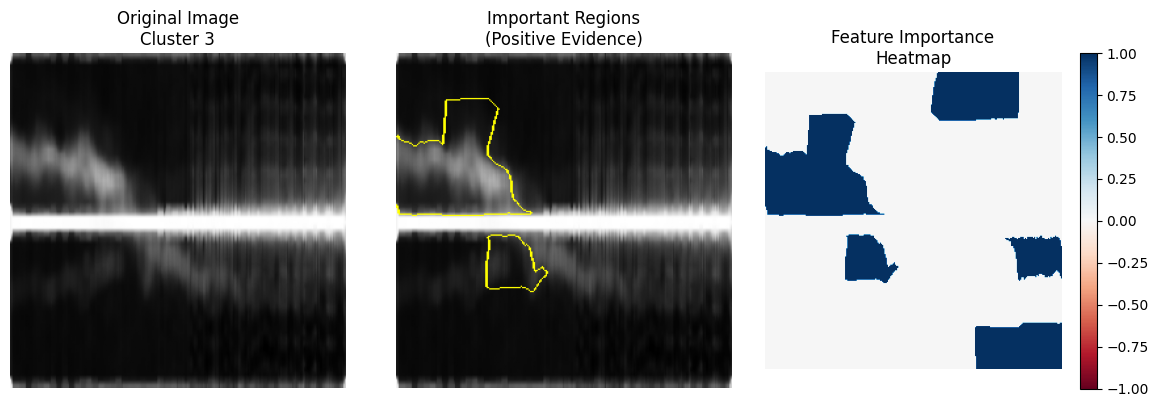


Top features for image B_4.png:
Feature 16: Importance = 0.055
Feature 15: Importance = 0.048
Feature 10: Importance = 0.039
Feature 31: Importance = 0.037
Feature 22: Importance = 0.030

Analyzing Cluster 4...


100%|██████████| 100/100 [00:00<00:00, 581.53it/s]


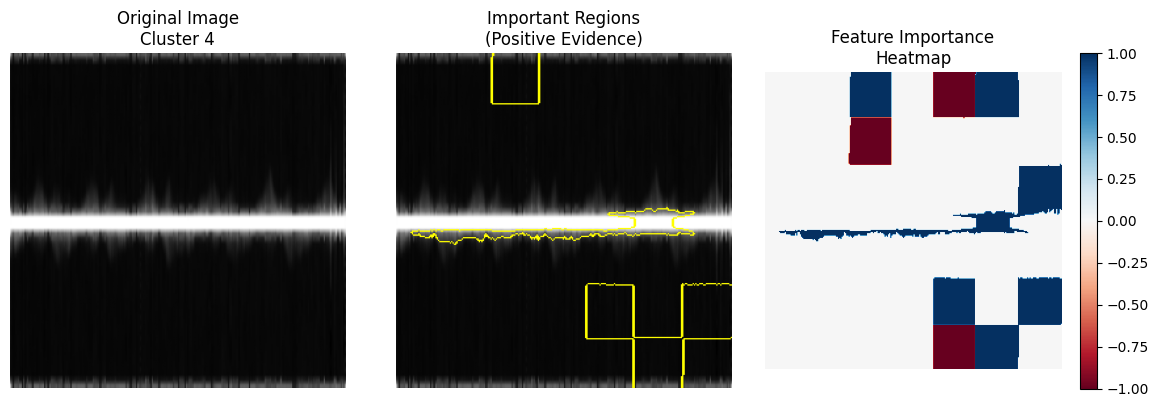


Top features for image A_6.png:
Feature 46: Importance = 0.015
Feature 3: Importance = 0.015
Feature 35: Importance = 0.011
Feature 23: Importance = 0.011
Feature 34: Importance = 0.009


100%|██████████| 100/100 [00:00<00:00, 595.57it/s]


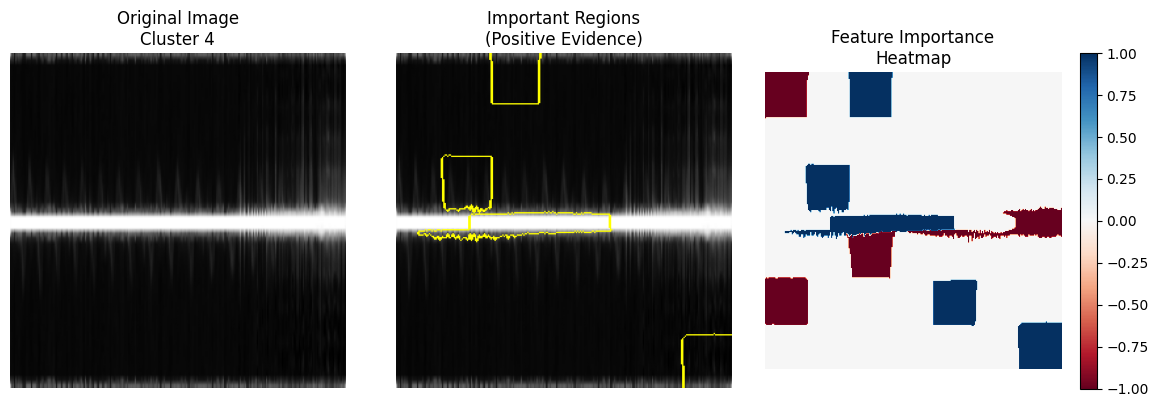


Top features for image A_1.png:
Feature 17: Importance = 0.059
Feature 28: Importance = -0.021
Feature 22: Importance = -0.017
Feature 26: Importance = 0.016
Feature 1: Importance = -0.014


100%|██████████| 100/100 [00:00<00:00, 575.76it/s]


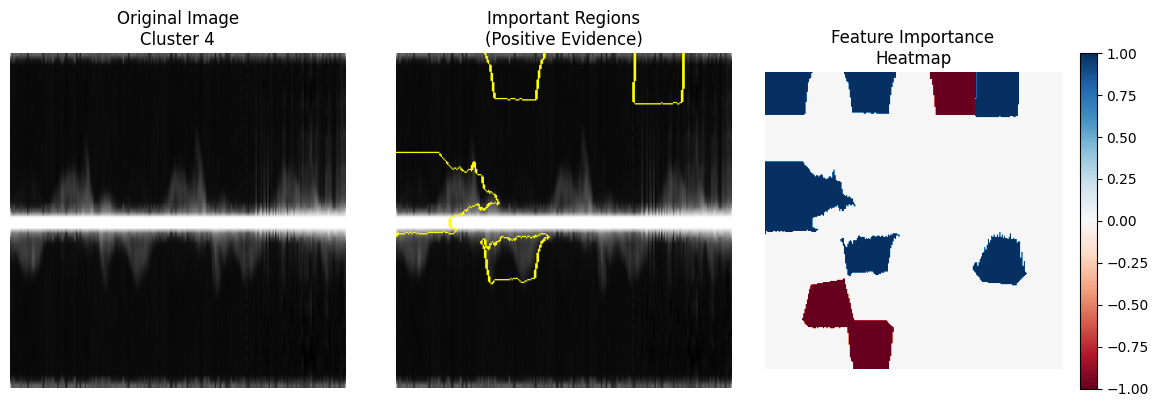


Top features for image C_6.png:
Feature 20: Importance = 0.043
Feature 17: Importance = 0.031
Feature 30: Importance = 0.024
Feature 5: Importance = -0.023
Feature 6: Importance = 0.019

Analyzing Cluster 5...


100%|██████████| 100/100 [00:00<00:00, 574.52it/s]


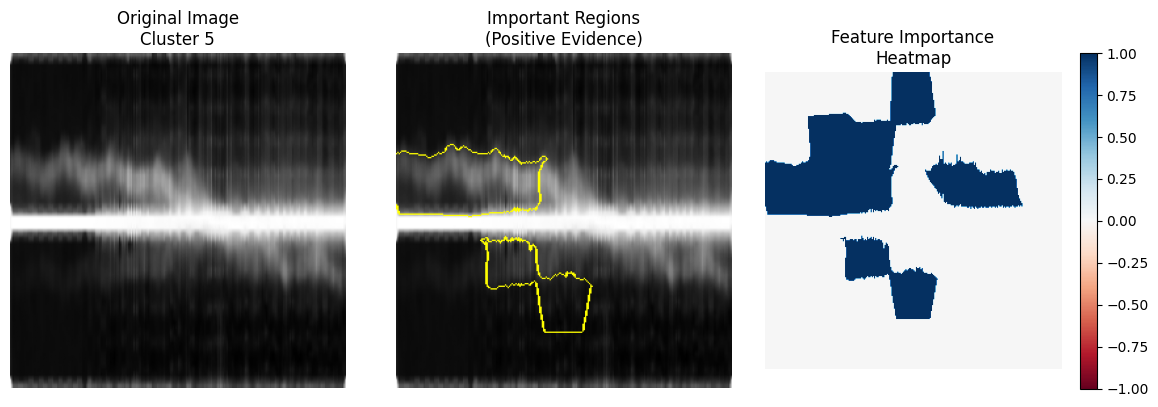


Top features for image C_11.png:
Feature 16: Importance = 0.073
Feature 17: Importance = 0.059
Feature 18: Importance = 0.045
Feature 31: Importance = 0.035
Feature 36: Importance = 0.035


100%|██████████| 100/100 [00:00<00:00, 563.09it/s]


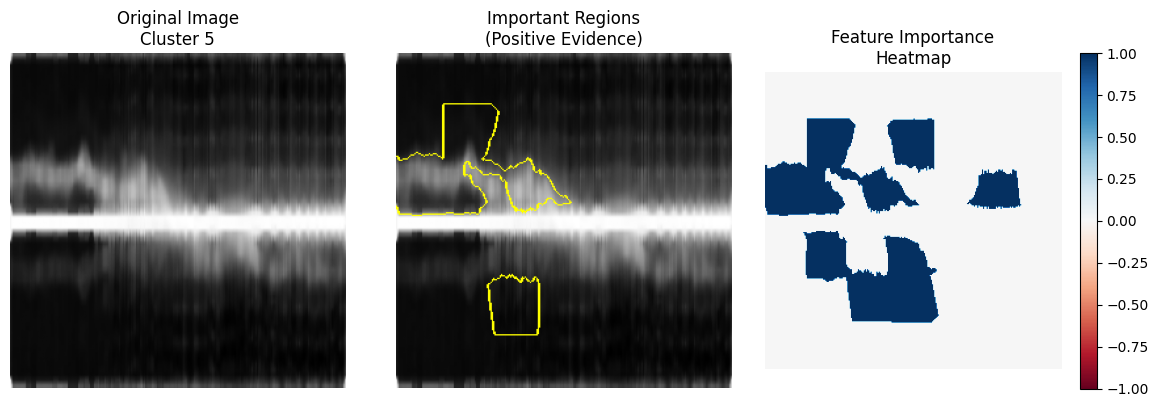


Top features for image C_9.png:
Feature 16: Importance = 0.066
Feature 15: Importance = 0.066
Feature 10: Importance = 0.050
Feature 19: Importance = 0.046
Feature 37: Importance = 0.039

Analyzing Cluster 6...


100%|██████████| 100/100 [00:00<00:00, 560.11it/s]


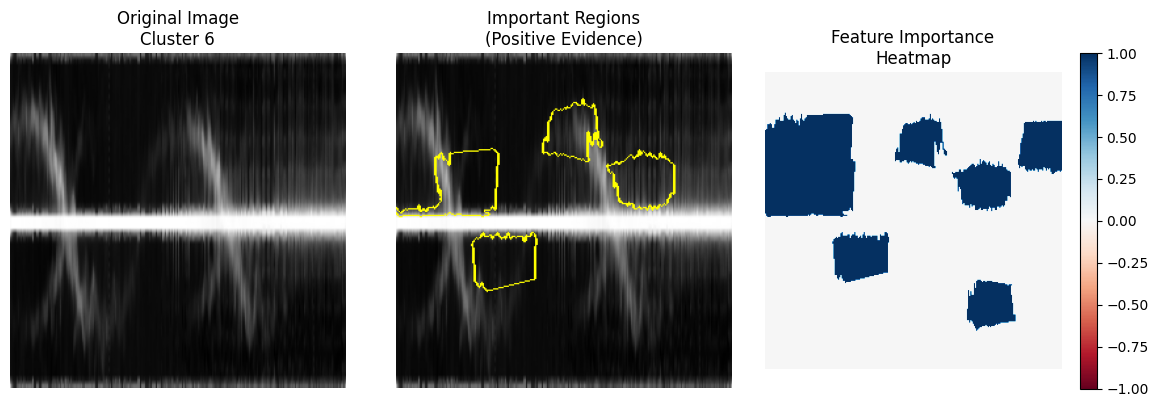


Top features for image C_5.png:
Feature 17: Importance = 0.053
Feature 18: Importance = 0.050
Feature 11: Importance = 0.050
Feature 20: Importance = 0.048
Feature 30: Importance = 0.048


100%|██████████| 100/100 [00:00<00:00, 588.86it/s]


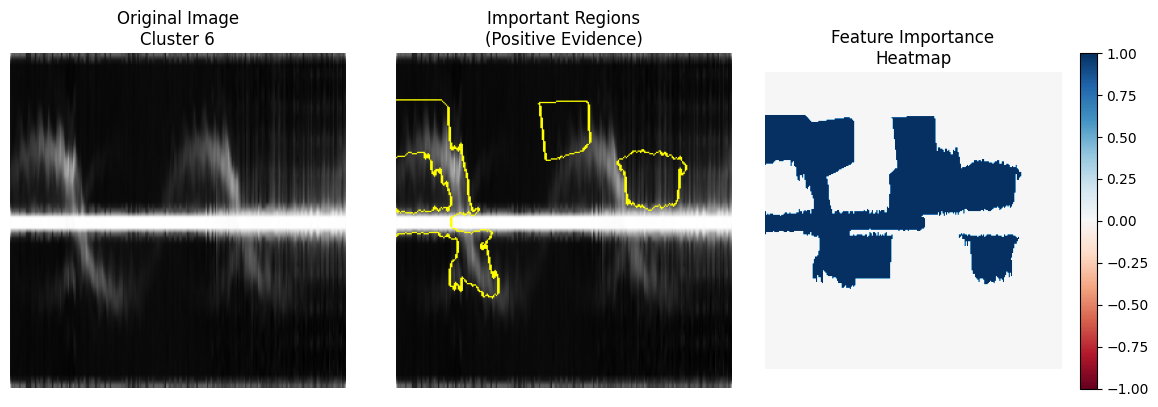


Top features for image B_3.png:
Feature 15: Importance = 0.093
Feature 11: Importance = 0.048
Feature 18: Importance = 0.039
Feature 25: Importance = 0.038
Feature 9: Importance = 0.035

Analyzing Cluster 7...


100%|██████████| 100/100 [00:00<00:00, 595.41it/s]


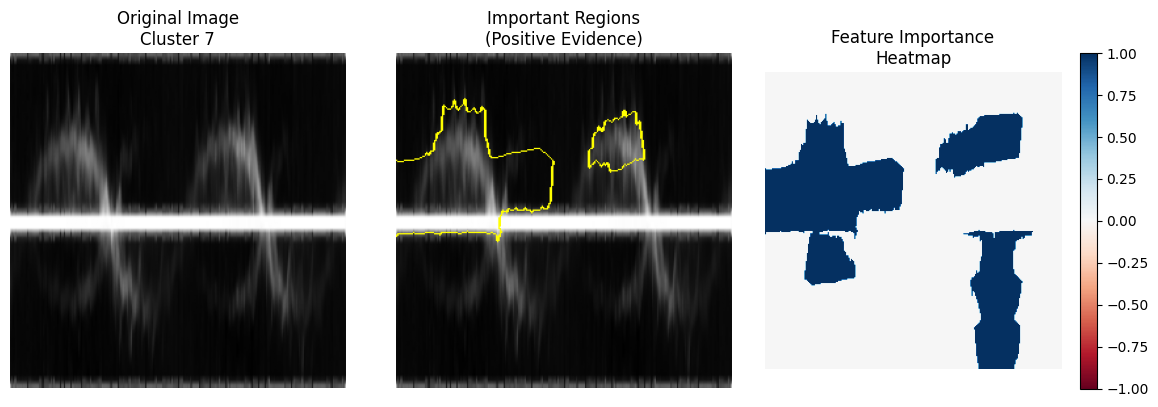


Top features for image A_3.png:
Feature 19: Importance = 0.088
Feature 15: Importance = 0.083
Feature 16: Importance = 0.064
Feature 14: Importance = 0.047
Feature 9: Importance = 0.042

Analyzing Cluster 8...


100%|██████████| 100/100 [00:00<00:00, 547.01it/s]


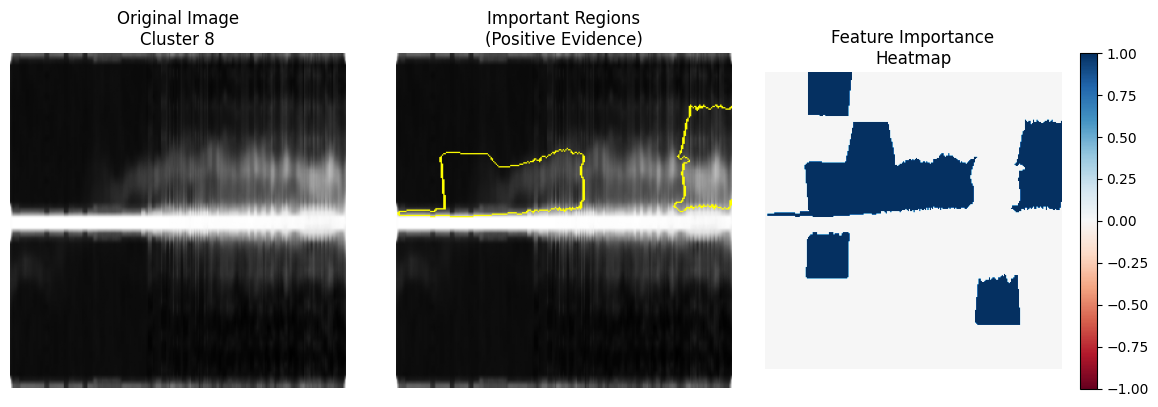


Top features for image B_11.png:
Feature 18: Importance = 0.070
Feature 13: Importance = 0.067
Feature 19: Importance = 0.048
Feature 21: Importance = 0.046
Feature 17: Importance = 0.046


100%|██████████| 100/100 [00:00<00:00, 579.23it/s]


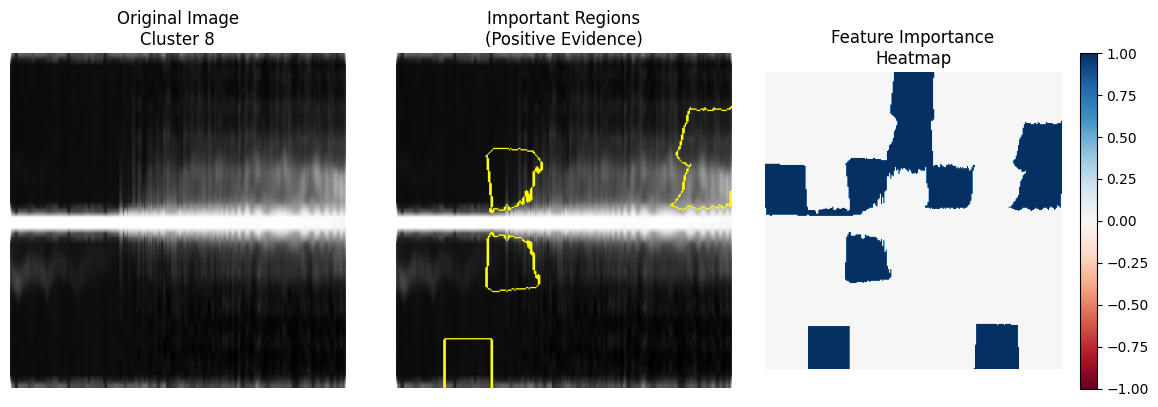


Top features for image B_10.png:
Feature 20: Importance = 0.089
Feature 15: Importance = 0.069
Feature 13: Importance = 0.065
Feature 47: Importance = 0.042
Feature 30: Importance = 0.041


100%|██████████| 100/100 [00:00<00:00, 535.12it/s]


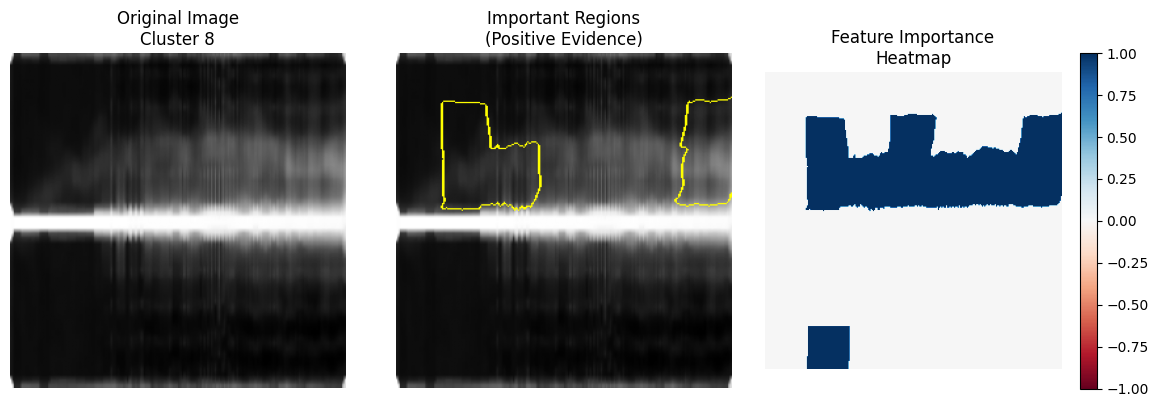


Top features for image B_5.png:
Feature 16: Importance = 0.118
Feature 19: Importance = 0.084
Feature 20: Importance = 0.060
Feature 13: Importance = 0.054
Feature 10: Importance = 0.045

Analyzing Cluster 9...


100%|██████████| 100/100 [00:00<00:00, 587.03it/s]


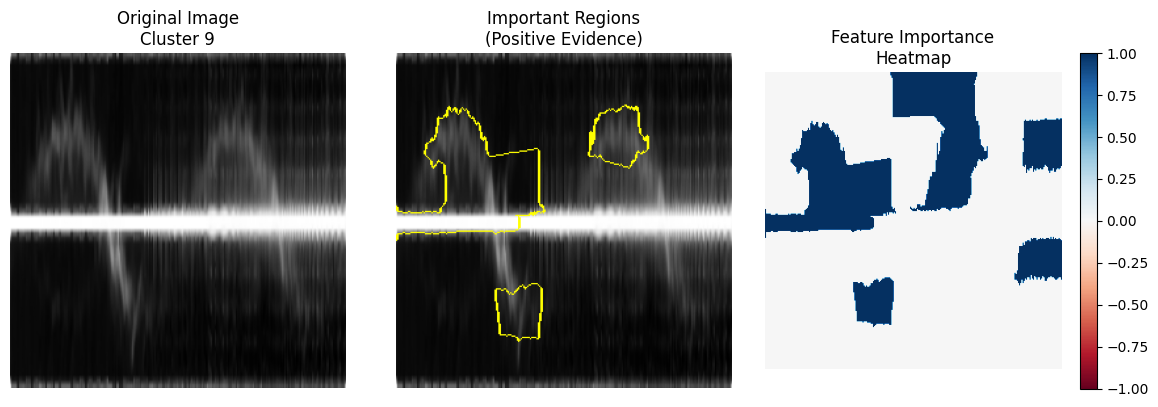


Top features for image A_4.png:
Feature 14: Importance = 0.052
Feature 20: Importance = 0.051
Feature 15: Importance = 0.051
Feature 36: Importance = 0.047
Feature 13: Importance = 0.046


100%|██████████| 100/100 [00:00<00:00, 561.97it/s]


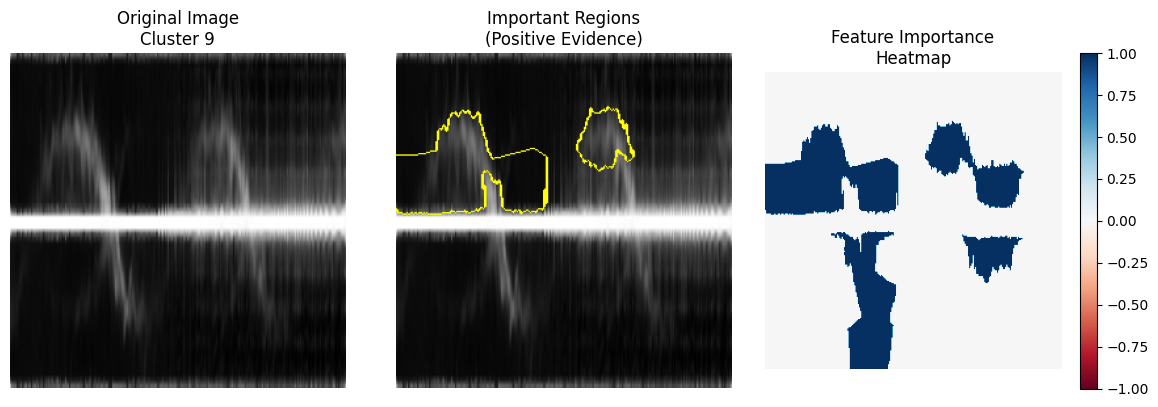


Top features for image A_5.png:
Feature 21: Importance = 0.064
Feature 14: Importance = 0.057
Feature 13: Importance = 0.056
Feature 15: Importance = 0.054
Feature 18: Importance = 0.039


In [4]:
analyzer = ClusterAnalyzer()

print("Loading dataset...")
analyzer.load_dataset()

print("Training surrogate model...")
analyzer.train_surrogate_model()

for cluster_num in range(len(set(analyzer.encoded_labels))):
    print(f"\nAnalyzing Cluster {cluster_num}...")
    analyzer.analyze_cluster(cluster_num)